In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import csv
import cv2 as cv2
import copy
import keras
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
import sklearn.preprocessing as skl
from PIL import Image, ImageOps
from os import listdir
from os.path import isfile, join
import zipfile  
import pickle

plt.ion()

Using TensorFlow backend.


In [123]:
base_model = VGG19(weights='imagenet')

In [124]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)

In [4]:
#base_model.summary()

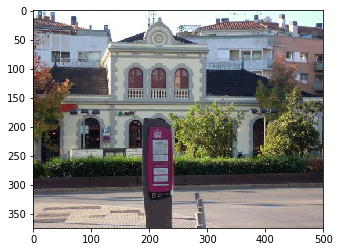

In [125]:
database = [f for f in listdir("./DBTB2019_2020/database-2065") if isfile(join("./DBTB2019_2020/database-2065", f))]            # Guardem a una llista tots els fitxer d'imatges que haurem de llegir
train = np.array([np.array(Image.open("./DBTB2019_2020/database-2065/" + fname)) for fname in database])                        # Llegim totes les imatges a una variable matriu (3D)

queries = [f for f in listdir("./DBTB2019_2020/queries-2061") if isfile(join("./DBTB2019_2020/queries-2061", f))]         # Guardem a una llista tots els fitxer d'imatges que haurem de llegir
test = np.array([np.array(Image.open("./DBTB2019_2020/queries-2061/" + fname)) for fname in queries])                      # Llegim totes les imatges a una variable matriu (3D)

# Provem que se'ns hagin guardat les imatges
plt.figure()                                   # Obrir figura per representar imatge
imatge = plt.imshow(test[1], cmap='gray') # Mostrar imatge a la figura oberta

In [128]:
#len(queries)
len(database)

2065

In [127]:
#IMATGES QUERIES
i=0
imatge = []
final = []
for i in range(len(queries)):
    imatge.append(image.load_img('./DBTB2019_2020/queries-2061/'+queries[i], target_size=(224,224)))
    final.append(image.img_to_array(imatge[i]))
    final[i] = np.expand_dims(final[i], axis=0)
    final[i] = preprocess_input(final[i])

In [88]:
len(imatge)  

2061

In [ ]:
imatge[11]

In [41]:
sortida = [] 
k = 0
for k in range(len(queries)):
    sortida.append(model.predict(final[k]))

In [89]:
len(sortida)

2061

In [42]:
#IMATGES DATABASE (TEST)
i2=0
imatge2=[]
final2=[]
for i2 in range(len(database)):
    imatge2.append(image.load_img('./DBTB2019_2020/database-2065/' + database[i2], target_size=(224,224)))
    final2.append(image.img_to_array(imatge2[i2]))
    final2[i2]=np.expand_dims(final2[i2],axis=0)
    final2[i2]=preprocess_input(final2[i2])

In [87]:
len(imatge2)

2065

In [ ]:
imatge2[1]

In [43]:
sortida2=[]
k2 = 0
for k2 in range(len(database)):
    sortida2.append(model.predict(final2[k2]))

In [48]:
descriptor = np.asarray(sortida)

In [49]:
descriptor2 = np.asarray(sortida2)

In [ ]:
# Per guardar els descriptors
#pickle.dump(descriptor, open("descriptor.p","wb"))

In [ ]:
# Per guardar els descriptors
#pickle.dump(descriptor2, open("descriptor2.p","wb"))

In [ ]:
# Per guardar les imatges
#pickle.dump(imatge, open("imatge.p","wb"))

In [ ]:
# Per guardar les imatges
#pickle.dump(imatge2, open("imatge2.p","wb"))

In [90]:
descriptor.shape

(2061, 1, 25088)

In [91]:
descriptor2.shape

(2065, 1, 25088)

In [92]:
descriptors_train = np.reshape(descriptor,(2061,25088))
descriptors_test = np.reshape(descriptor2,(2065,25088))

In [93]:
x_train_normalized = skl.normalize(descriptors_train, norm='l2', axis=1, copy=True, return_norm=False)
x_test_normalized = skl.normalize(descriptors_test, norm='l2', axis=1, copy=True, return_norm=False)

In [94]:
x_train_normalized = x_train_normalized.transpose()

In [112]:
similarities = np.matmul(x_test_normalized,x_train_normalized)

In [96]:
len(similarities)

2065

In [113]:
ranks = np.argsort(similarities, axis=1)[:,::-1]

In [98]:
len(ranks)

2065

In [114]:
# GET ORIGINAL IMAGES FOR VISUALIZATION
x_test_imatges = []
x_train_imatges = []

In [115]:
v = 0
for v in range(2061): 
    x_train_imatges.append(np.array(imatge[v]))
    

In [116]:
b = 0
for b in range(2065): 
    x_test_imatges.append(np.array(imatge2[b]))
    

In [117]:
h,w = (224, 224)
new_image=Image.new('RGB', (h*5,w*13))

In [118]:
# Visualize ranks of the 10 queries
offset = 10 # it will show results from query #'offset' to #offset+10
for q in range(13):
  ranks_q = ranks[q*(offset+1),:]
  for i in range(4):
      new_image.paste(Image.fromarray(x_train_imatges[ranks_q[i]]), (h*(1+i),w*q))

  # visualize query
      ima_q = Image.fromarray(x_test_imatges[q*(offset+1)])
      ima_q = ImageOps.expand(ima_q, border=20, fill='red')

      new_image.paste(ima_q, (0,w*q))
      

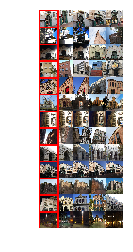

In [119]:
plt.imshow(new_image)
plt.axis('off')
plt.show()

In [120]:
csv1=[]
row1=["Query", "RetrievedDocuments"]

In [121]:
for q in range (2065): #Imatges TEST que tenim
    ranks_q = ranks[q,:]
    csv2 = []
    csv2.append(database[q])
    for i in range (2061): #Imatges TRAIN que tenim
        if i == 0:
            name = queries[ranks_q[i]]
        if i == 2061:
            name = name + '\n'
        else:
            name = name + ' ' + queries[ranks_q[i]]
    csv2.append(name)
    csv1.append(csv2)
    

In [122]:
with open("Ranking3_Equip2.csv",'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(row1)
    for z in range(2065):
        wr.writerow(csv1[z])